### Source
Example from @bwengals
https://discourse.pymc.io/t/coregionalization-model-for-two-separable-multidimensional-gaussian-process/2550/4

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)

### generate and then plot the data

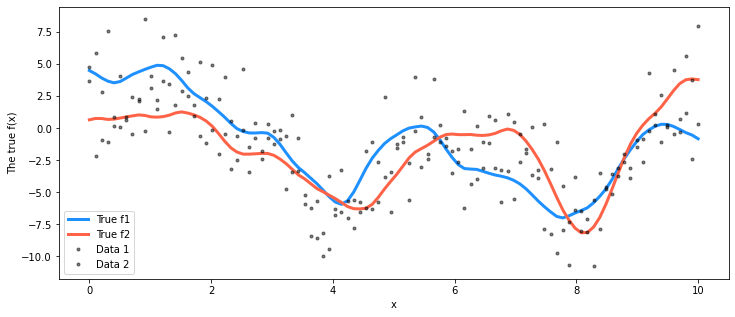

In [2]:
n = 100 
x = np.linspace(0, 10, n)[:, None] 

# true covariance function and its true parameters
ell_true = 1.0
eta_true = 3.0
cov_func = eta_true**2 * pm.gp.cov.Matern52(1, ell_true)
mean_func = pm.gp.mean.Zero()

# two samples from the same gaussian process
f_true1 = np.random.multivariate_normal(mean_func(x).eval(),
                                        cov_func(x).eval() + 1e-8*np.eye(n), 1).flatten()
f_true2 = np.random.multivariate_normal(mean_func(x).eval(),
                                        cov_func(x).eval() + 1e-8*np.eye(n), 1).flatten()


sigma_true = 2.0
f1 = 0.5*f_true1 - 1.0*f_true2
f2 = 1.0*f_true1 + 0.2*f_true2
y1 = f1 + sigma_true * np.random.randn(n)
y2 = f2 + sigma_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(x, f1, "dodgerblue", lw=3, label="True f1");
ax.plot(x, f2, "tomato", lw=3, label="True f2");
ax.plot(x, y1, 'ok', ms=3, alpha=0.5, label="Data 1");
ax.plot(x, y2, 'ok', ms=3, alpha=0.5, label="Data 2");
ax.set_xlabel("x"); ax.set_ylabel("The true f(x)"); plt.legend();

### Format the data for the coregionalized GP

In [3]:
x.shape, y1.shape, y2.shape

((100, 1), (100,), (100,))

In [4]:
xx = np.concatenate((x, x), axis=0)
idx = np.concatenate((np.zeros(n), np.ones(n)))[:,None]
X = np.concatenate((xx, idx), axis=1)

y = np.concatenate((y1, y2))
X.shape, y.shape

((200, 2), (200,))

### pymc model

In [12]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=2, beta=0.5)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell, active_dims=[0])
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=2)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    cov_func = coreg * cov
    
    sigma = pm.HalfNormal("sigma", sigma=3)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("f", X, y, noise=sigma)

/tmp/ipykernel_20201/46575181.py:6: FutureWarning: The `testval` argument is deprecated; use `initval`.
  W = pm.Normal("W", mu=0, sigma=3, shape=(2,2), testval=np.random.randn(2,2))


### MAP estimate and generate some predictions

In [13]:
with model:
    mp = pm.find_MAP()

In [14]:
x_new = np.linspace(0, 20, 200)[:, None]
xx_new = np.concatenate((x_new, x_new), axis=0)
idx2 = np.concatenate((np.zeros(200), np.ones(200)))[:, None]
X_new = np.concatenate((xx_new, idx2), axis=1)

In [15]:
x_new.shape, xx_new.shape, idx2.shape, X_new.shape

((200, 1), (400, 1), (400, 1), (400, 2))

In [16]:
with model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], var_names=['f_pred'])


### Plot

In [46]:
f_pred = pred_samples.posterior_predictive["f_pred"].squeeze().values
f_pred[:200].shape

(200,)

In [47]:
x.shape

(100, 1)

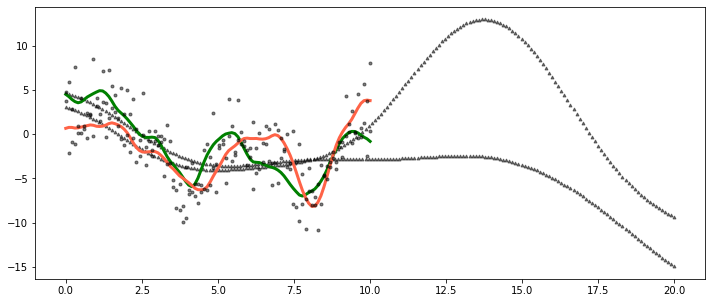

In [48]:
from pymc.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = pred_samples.posterior_predictive["f_pred"].squeeze().values
# plot_gp_dist(ax, f_pred[:200], X_new[:200,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
# plot_gp_dist(ax, f_pred[200:], X_new[200:,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
ax.plot(X_new[:200,0], f_pred[:200], '^k', ms=3, alpha=0.5, label="Data 1");
ax.plot( X_new[200:,0], f_pred[200:], '^k', ms=3, alpha=0.5, label="Data 2");

ax.plot(x, f1, "green", lw=3, label="True f1");
ax.plot(x, f2, "tomato", lw=3, label="True f2");
ax.plot(x, y1, 'ok', ms=3, alpha=0.5, label="Data 1");
ax.plot(x, y2, 'ok', ms=3, alpha=0.5, label="Data 2");

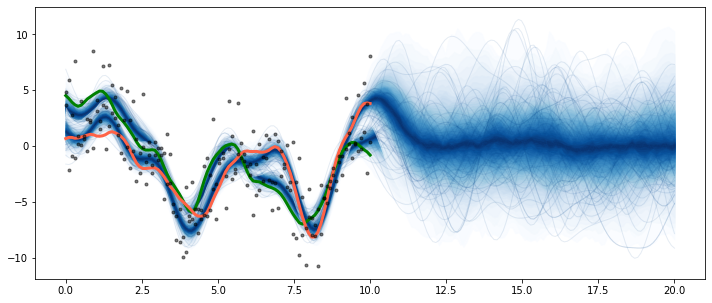

In [55]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

f_pred = pred_samples["f_pred"]
plot_gp_dist(ax, f_pred[:, :200], X_new[:200,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
plot_gp_dist(ax, f_pred[:, 200:], X_new[200:,0], palette="Blues", fill_alpha=0.5, samples_alpha=0.1)

ax.plot(x, f1, "green", lw=3, label="True f1");
ax.plot(x, f2, "tomato", lw=3, label="True f2");
ax.plot(x, y1, 'ok', ms=3, alpha=0.5, label="Data 1");
ax.plot(x, y2, 'ok', ms=3, alpha=0.5, label="Data 2");